In [196]:
# Imports

import pandas as pd
import biogeme.biogeme as bio
import biogeme.database as db
from biogeme import models
from biogeme.expressions import Beta
from biogeme.tools import likelihood_ratio_test
import numpy as np
import matplotlib.pyplot as plt

In [174]:
# initialising data
df = pd.read_csv('Dataset 1 2024.csv')
df.rename(columns={'Unnamed: 0':'ID','CAR OWNERSHIP':'CAR_OWNERSHIP'}, inplace=True)
db = db.Database("Dataset 1 2024",df)

# Model Estimation

In [175]:
## creating the model parameters

# general parameters
BetaTT = Beta('BetaTT', 0, None, None, 0)
BetaTC = Beta('BetaTC', 0, None, None, 0)

# total cost parameters
BetaTC_car = Beta('BetaTC_car', 0, None, None, 0)
BetaTC_PT = Beta('BetaTC_PT', 0, None, None, 0)
BetaTC_cycling = Beta('BetaTC_cycling', 0, None, None, 0)
BetaTC_walking = Beta('BetaTC_walking', 0, None, None, 0)

# car alternative specific constants
Beta0_car = Beta('Beta0_car', 0, None, None, 0)
BetaTT_car = Beta('BetaTT_car', 0, None, None, 0)
BetaFuel_car = Beta('BetaFuel_car', 0, None, None, 0)
BetaParking_car = Beta('BetaParking_car', 0, None, None, 0)
BetaCongestion_car = Beta('BetaCongestion_car', 0, None, None, 0)

# public transport alternative specific constants
Beta0_PT = Beta('Beta0_PT', 0, None, None, 0)
BetaTT_PT = Beta('BetaTT_PT', 0, None, None, 0)
BetaFare_PT = Beta('BetaFare_PT', 0, None, None, 0)
BetaAC_PT = Beta('BetaAC_PT', 0, None, None, 0)
BetaAT_PT = Beta('BetaAT_PT', 0, None, None, 0)
BetaWT_PT = Beta('BetaWT_PT', 0, None, None, 0)


# cycling alternative specific constants
Beta0_cycling = Beta('Beta0_cycling', 0, None, None, 0)
BetaTT_cycling = Beta('BetaTT_cycling', 0, None, None, 0)
BetaBikeability_cycling = Beta('BetaBikeability_cycling', 0, None, None, 0)

# walking alternative specific constants
Beta0_walking = Beta('Beta0_walking', 0, None, None, 1)
BetaTT_walking = Beta('BetaTT_walking', 0, None, None, 0)
BetaWalkability_walking = Beta('BetaWalkability_walking', 0, None, None, 0)

# demographic attribute generic parameters
BetaAge = Beta('BetaAge', 0, None, None, 0)
BetaGender = Beta('BetaGender', 0, None, None, 0)
BetaIncome = Beta('BetaIncome', 0, None, None, 0)
BetaCarOwnership = Beta('BetaCarOwnership', 0, None, None, 0)


In [176]:
globals().update(db.variables)

In [177]:
# baseline utility functions
baseline_user = BetaAge * AGE + BetaGender * GENDER + BetaIncome * INCOME + BetaCarOwnership * CAR_OWNERSHIP

V_baseline_car = Beta0_car + BetaTT_car * TT_CAR + BetaFuel_car * FC_CAR + BetaParking_car * PC_CAR + BetaCongestion_car * CC_CAR + baseline_user
V_baseline_PT = Beta0_PT + BetaTT_PT * TT_PT + BetaFare_PT * FARE_PT + BetaAC_PT * AC_PT + BetaAT_PT * AT_PT + BetaWT_PT * WT_PT + baseline_user
V_baseline_cycling = Beta0_cycling + BetaTT_cycling * TT_CYCLE + BetaBikeability_cycling * BIKEABILITY_INDEX + baseline_user
V_baseline_walking = Beta0_walking + BetaTT_walking * TT_WALK + BetaWalkability_walking * WALKABILITY_INDEX + baseline_user

In [178]:
# generalised utility functions for chi squared test

V_baseline_car_generalised = Beta0_car + BetaTT * TT_CAR + BetaTC * (FC_CAR + PC_CAR + CC_CAR) + baseline_user
V_baseline_PT_generalised = Beta0_PT + BetaTT * TT_PT + BetaTC * (FARE_PT + AC_PT + AT_PT + WT_PT) + baseline_user
V_baseline_cycling_generalised = Beta0_cycling + BetaTT * TT_CYCLE + BetaTC * BIKEABILITY_INDEX + baseline_user
V_baseline_walking_generalised = Beta0_walking + BetaTT * TT_WALK + BetaTC * WALKABILITY_INDEX + baseline_user

In [179]:
# model that compiles all the costs together for alternative specific constants for chi squared test again

V_baseline_car_totalcost = Beta0_car + BetaTT_car * TT_CAR + BetaTC_car * (FC_CAR + PC_CAR + CC_CAR) + baseline_user
V_baseline_PT_totalcost = Beta0_PT + BetaTT_PT * TT_PT + BetaTC_PT * (FARE_PT + AC_PT + AT_PT + WT_PT) + baseline_user
V_baseline_cycling_totalcost = Beta0_cycling + BetaTT_cycling * TT_CYCLE + BetaTC_cycling * BIKEABILITY_INDEX + baseline_user
V_baseline_walking_totalcost = Beta0_walking + BetaTT_walking * TT_WALK + BetaTC_walking * WALKABILITY_INDEX + baseline_user

In [180]:
# associate utility functions with the numbering of alternatives
V_base = {4: V_baseline_car, 3: V_baseline_PT, 2: V_baseline_cycling, 1: V_baseline_walking}
V_base_generalised = {4: V_baseline_car_generalised, 3: V_baseline_PT_generalised, 2: V_baseline_cycling_generalised, 1: V_baseline_walking_generalised}
V_base_totalcost = {4: V_baseline_car_totalcost, 3: V_baseline_PT_totalcost, 2: V_baseline_cycling_totalcost, 1: V_baseline_walking_totalcost}
av = {4: 1, 3: 1, 2: 1, 1: 1}

In [181]:
# logit model
logprob_base = models.loglogit(V_base, av, CHOSEN_MODE)
logprob_base_generalised = models.loglogit(V_base_generalised, av, CHOSEN_MODE)
logprob_base_totalcost = models.loglogit(V_base_totalcost, av, CHOSEN_MODE)

In [182]:
# initialising the models
baseline = bio.BIOGEME(db, logprob_base)
baseline_generalised = bio.BIOGEME(db, logprob_base_generalised)
baseline_totalcost = bio.BIOGEME(db, logprob_base_totalcost)

baseline.modelName = "baseline_model"
baseline_generalised.modelName = "baseline_generalised_model"
baseline_totalcost.modelName = "baseline_totalcost_model"

In [183]:
# baseline model estimation
results_baseline = baseline.estimate()
results_baseline.get_estimated_parameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
Beta0_PT,3.356366e+00,3.259708e-01,10.296522,0.000000e+00
Beta0_car,3.044512e+00,1.721684e-01,17.683335,0.000000e+00
Beta0_cycling,6.438489e-02,9.854961e-02,0.653325,5.135470e-01
BetaAC_PT,-5.667310e-01,4.436359e-02,-12.774690,0.000000e+00
BetaAT_PT,-9.698061e-02,9.415210e-03,-10.300419,0.000000e+00
BetaAge,-7.380632e-14,1.961691e-14,-3.762383,1.683018e-04
BetaBikeability_cycling,5.355559e-03,8.614293e-04,6.217062,5.065504e-10
BetaCarOwnership,9.515456e-17,5.295153e-15,0.017970,9.856627e-01
BetaCongestion_car,-1.294034e-01,1.293246e-02,-10.006095,0.000000e+00
BetaFare_PT,-1.137915e+00,6.898014e-02,-16.496271,0.000000e+00


In [184]:
# baseline generalised model estimation
results_baseline_generalised = baseline_generalised.estimate()
results_baseline_generalised.get_estimated_parameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
Beta0_PT,-2.984911e+00,6.383947e-02,-4.675652e+01,0.000000e+00
Beta0_car,-9.859077e-01,3.925295e-02,-2.511678e+01,0.000000e+00
Beta0_cycling,-1.413638e-01,2.684252e-02,-5.266414e+00,1.391142e-07
BetaAge,-7.216421e-15,1.972906e-17,-3.657762e+02,0.000000e+00
BetaCarOwnership,9.274919e-18,8.778636e-20,1.056533e+02,0.000000e+00
BetaGender,1.505564e-17,4.818747e-20,3.124389e+02,0.000000e+00
BetaIncome,-9.345428e-15,1.797693e+308,-5.434722e-323,1.000000e+00
BetaTC,4.777857e-03,5.950271e-04,8.029647e+00,8.881784e-16
BetaTT,-7.317127e-02,1.178168e-03,-6.210596e+01,0.000000e+00


In [185]:
# baseline total cost model estimation
results_baseline_totalcost = baseline_totalcost.estimate()
results_baseline_totalcost.get_estimated_parameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
Beta0_PT,4.636015e-01,2.477302e-01,1.871397e+00,6.129011e-02
Beta0_car,2.515980e+00,1.575676e-01,1.596763e+01,0.000000e+00
Beta0_cycling,6.887743e-02,9.772029e-02,7.048426e-01,4.809082e-01
BetaAge,7.466399e-14,1.797693e+308,4.150151e-322,1.000000e+00
BetaCarOwnership,2.733280e-17,7.001766e-14,3.903701e-04,9.996885e-01
BetaGender,-4.750387e-16,1.797693e+308,-4.940656e-324,1.000000e+00
BetaIncome,-3.912357e-14,5.878772e-15,-6.655058e+00,2.831890e-11
BetaTC_PT,-1.081079e-01,7.208485e-03,-1.499732e+01,0.000000e+00
BetaTC_car,-1.955748e-01,9.505163e-03,-2.057564e+01,0.000000e+00
BetaTC_cycling,5.365577e-03,8.516906e-04,6.299913e+00,2.978129e-10


# Analysis

In [186]:
# extracting the general statistics
baseline_stats = results_baseline.getGeneralStatistics()
baseline_generalised_stats = results_baseline_generalised.getGeneralStatistics()
baseline_totalcost_stats = results_baseline_totalcost.getGeneralStatistics()

C:\Users\majdy\AppData\Local\Temp\ipykernel_8232\3121988993.py:2: DeprecationWarning: getGeneralStatistics is deprecated; use get_general_statistics instead.
  baseline_stats = results_baseline.getGeneralStatistics()
C:\Users\majdy\AppData\Local\Temp\ipykernel_8232\3121988993.py:3: DeprecationWarning: getGeneralStatistics is deprecated; use get_general_statistics instead.
  baseline_generalised_stats = results_baseline_generalised.getGeneralStatistics()
C:\Users\majdy\AppData\Local\Temp\ipykernel_8232\3121988993.py:4: DeprecationWarning: getGeneralStatistics is deprecated; use get_general_statistics instead.
  baseline_totalcost_stats = results_baseline_totalcost.getGeneralStatistics()


In [187]:
#likelihood ratio test between the generalised model and the baseline model

LRbase = [baseline_stats['Final log likelihood'].value, baseline_stats['Number of estimated parameters'].value]
LRgeneralised = [baseline_generalised_stats['Final log likelihood'].value, baseline_generalised_stats['Number of estimated parameters'].value]

LR_test_1 = likelihood_ratio_test(LRgeneralised, LRbase)
LR_test_1

LRTuple(message='H0 can be rejected at level 5.0%', statistic=1652.0390671734222, threshold=np.float64(19.67513757268249))

In [188]:
# likelihood ratio test between the total cost model and the baseline model

LRtotalcost = [baseline_totalcost_stats['Final log likelihood'].value, baseline_totalcost_stats['Number of estimated parameters'].value]

LR_test_2 = likelihood_ratio_test(LRtotalcost, LRbase)
LR_test_2

LRTuple(message='H0 can be rejected at level 5.0%', statistic=727.4611186908423, threshold=np.float64(11.070497693516351))

# interventions

In [195]:
# Define percentage reductions for access time
percentage_times = np.linspace(0, 1, 11)
percentage_costs = np.linspace(0, 1, 11)

# initialise market share arrays
pt_market_share = np.zeros((len(percentage_times),len(percentage_costs)))
cycling_market_share = np.zeros((len(percentage_times),len(percentage_costs)))
walking_market_share = np.zeros((len(percentage_times),len(percentage_costs)))
car_market_share = np.zeros((len(percentage_times),len(percentage_costs)))

# Loop through each percentage reduction
for j, perccost in enumerate(percentage_costs):
    for i, perctime in enumerate(percentage_times):
        # Define utility function with reduced access time
        V_intervention_PT = (Beta0_PT +
                             BetaTT_PT * TT_PT + 
                             BetaFare_PT * FARE_PT +
                             BetaAC_PT * AC_PT*(1-perccost) +
                             BetaAT_PT * AT_PT*(1-perctime) + 
                             BetaWT_PT * WT_PT + 
                             baseline_user)
        
        # Create a new utility functions dictionary for this scenario
        V_intervention = {4: V_baseline_car, 3: V_intervention_PT, 2: V_baseline_cycling, 1: V_baseline_walking}

        # # Estimate the model for Intervention 2
        # logprob_intervention2 = models.loglogit(V_intervention2, av, CHOSEN_MODE)
        # model_intervention2 = bio.BIOGEME(db, logprob_intervention2)
        # model_intervention2.modelName = f'intervention2_{int(percentage*100)}'
        # results_intervention2 = model_intervention2.estimate()

        simulate = {'Prob. Car': models.logit(V_intervention, av, 4),
                    'Prob. Public Transport': models.logit(V_intervention, av, 3),
                    'Prob. Cycling': models.logit(V_intervention, av, 2),
                    'Prob. Walking': models.logit(V_intervention, av, 1)}
        
        biosim_intervention = bio.BIOGEME(db, simulate)
        biosim_intervention.modelName = f'intervention_time{int(perctime)}_cost{int(perccost)}_simulation'
        
        # Simulate and calculate market shares
        simulated_values = biosim_intervention.simulate(the_beta_values=results_baseline.get_beta_values())
        probabilities = simulated_values.mean(axis=0)
        
        # Normalize probabilities to ensure they sum to one
        total_probabilities = probabilities.sum()
        market_shares = probabilities / total_probabilities

        # store the market shares into the arrays
        pt_market_share[i,j] = market_shares[1]
        cycling_market_share[i,j] = market_shares[2]
        walking_market_share[i,j] = market_shares[3]
        car_market_share[i,j] = market_shares[0]

        print(f'iteration {i,j} completed')
        
        # # Store market shares in the DataFrame
        # market_shares_df.loc[f'{int(percentage*100)}%'] = [
        #     market_shares_2[0],  # Car
        #     market_shares_2[1],  # Public Transport
        #     market_shares_2[2],  # Cycling
        #     market_shares_2[3]   # Walking
        # ]



C:\Users\majdy\AppData\Local\Temp\ipykernel_8232\494036799.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pt_market_share[i,j] = market_shares_2[1]
C:\Users\majdy\AppData\Local\Temp\ipykernel_8232\494036799.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cycling_market_share[i,j] = market_shares_2[2]
C:\Users\majdy\AppData\Local\Temp\ipykernel_8232\494036799.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  walking_mar

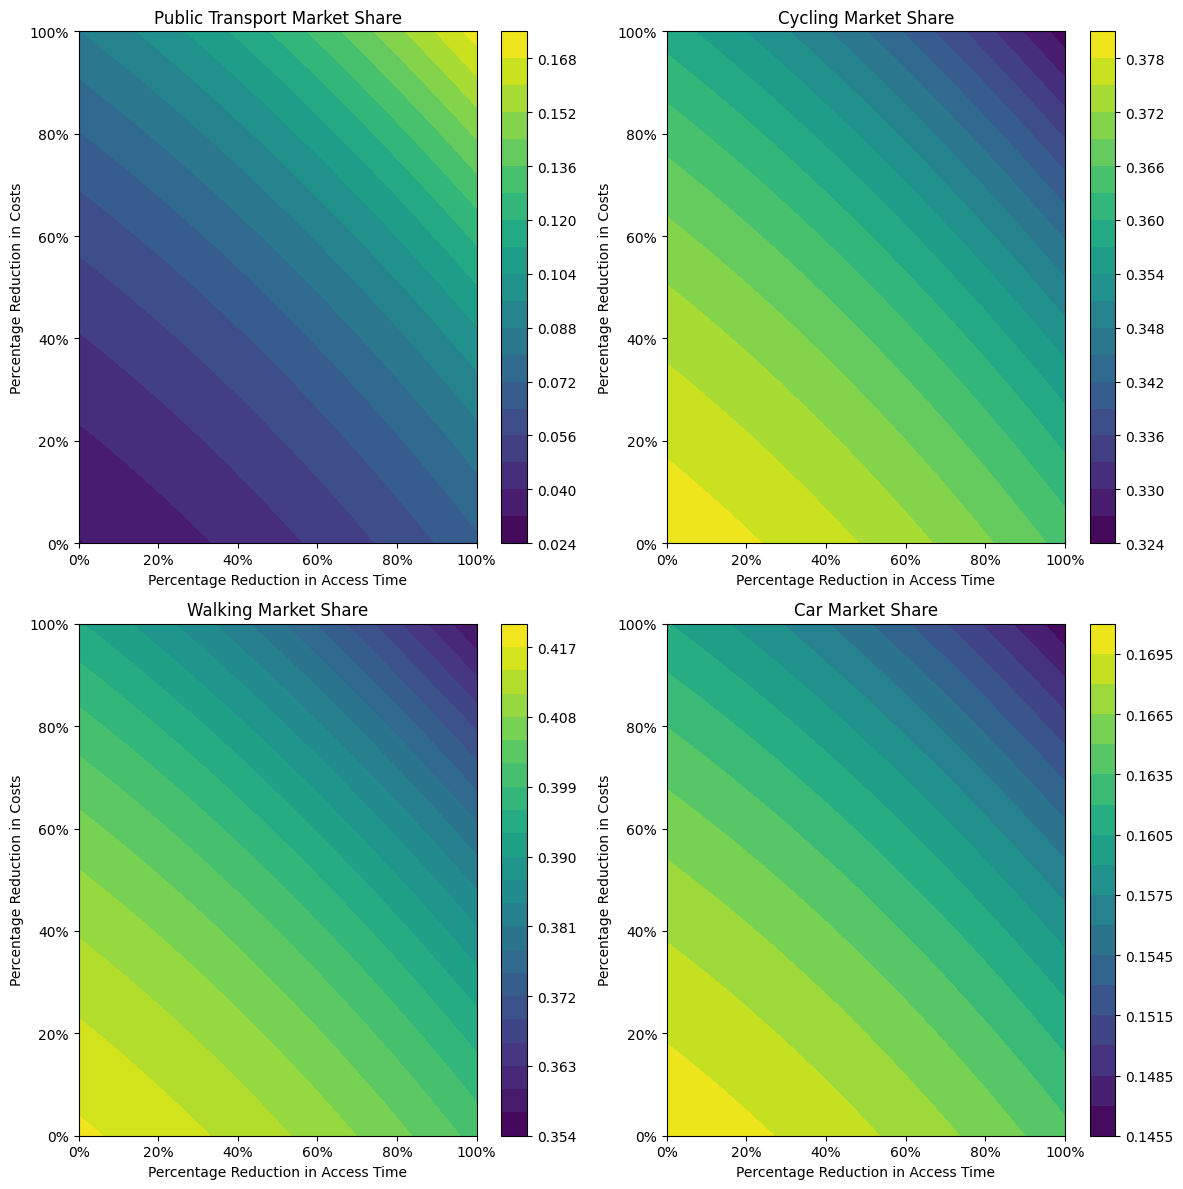

In [198]:
from matplotlib.ticker import PercentFormatter

# meshgrid for the contour plots
X, Y = np.meshgrid(percentage_times, percentage_costs)

# contour plots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Public Transport
cs1 = axs[0, 0].contourf(X, Y, pt_market_share, levels=20)
fig.colorbar(cs1, ax=axs[0, 0])
axs[0, 0].set_title('Public Transport Market Share')
axs[0, 0].set_xlabel('Percentage Reduction in Access Time')
axs[0, 0].set_ylabel('Percentage Reduction in Costs')
axs[0, 0].xaxis.set_major_formatter(PercentFormatter(1))
axs[0, 0].yaxis.set_major_formatter(PercentFormatter(1))

# Cycling
cs2 = axs[0, 1].contourf(X, Y, cycling_market_share, levels=20)
fig.colorbar(cs2, ax=axs[0, 1])
axs[0, 1].set_title('Cycling Market Share')
axs[0, 1].set_xlabel('Percentage Reduction in Access Time')
axs[0, 1].set_ylabel('Percentage Reduction in Costs')
axs[0, 1].xaxis.set_major_formatter(PercentFormatter(1))
axs[0, 1].yaxis.set_major_formatter(PercentFormatter(1))

# Walking
cs3 = axs[1, 0].contourf(X, Y, walking_market_share, levels=20)
fig.colorbar(cs3, ax=axs[1, 0])
axs[1, 0].set_title('Walking Market Share')
axs[1, 0].set_xlabel('Percentage Reduction in Access Time')
axs[1, 0].set_ylabel('Percentage Reduction in Costs')
axs[1, 0].xaxis.set_major_formatter(PercentFormatter(1))
axs[1, 0].yaxis.set_major_formatter(PercentFormatter(1))

# Car
cs4 = axs[1, 1].contourf(X, Y, car_market_share, levels=20)
fig.colorbar(cs4, ax=axs[1, 1])
axs[1, 1].set_title('Car Market Share')
axs[1, 1].set_xlabel('Percentage Reduction in Access Time')
axs[1, 1].set_ylabel('Percentage Reduction in Costs')
axs[1, 1].xaxis.set_major_formatter(PercentFormatter(1))
axs[1, 1].yaxis.set_major_formatter(PercentFormatter(1))

plt.tight_layout()
plt.show()